**The problem:**

I realized that I made the limvar ensemble incorrectly... my ensemble generation framework requries the user to specify a directory containing initial conditions, which it will use to initialize the members of the ensemble, create and submit them

Because of this, I decided to do the following:

1) Generate a series of runs with no eruption, and varries `pertlim` values on the order 1e-4
2) Identify a time into these runs where the spread between the members becomes "sufficient", but still "limited". This was determinied to be 90 days
3) Output an initial condition at this time for each run
4) Use those initial conditions to initialize an ensemble of injection runs

Later, it was determined that this was good, but actually, we want each injection run to include the 90 days pre-injection, i.e. the period over which the desired limited amount of variability it building. The runs would be very similar at early times, but that wasn't an issue.

To make this change, I simply decided to output initial conditions at day 1, rather than day 90 (as in (2) in the list above). With this new, earleir set of initial conditions, we build the limvar HSW ensemble.

I later realized that this was a mistake. Because I was outputting the initial states as "init" files, rather than proper "restart" files, the data values were all truncated to single-percision floats, i.e. an extra perturbation of something like 1e-7...

This ensemble will be referred to as the `og` ensemble

I gained supisioncs, as I went through the data, that this was causing the limvar ensemble to behave more like a fullvar ensemble... 

To check, I reran a new ensemble without any perturbed initial conditions. Instead, all runs share one unique IC, and all use `pertlim` internally. They then wait 90 days before starting the injection.

This ensemble will be referred to as the `fix` ensemble

After talking to Diana, we weren't sure if the HSW varied-mass limvar ensemble run by Jerry behvaed more like `og` or like `limvar`. Moreover, we weren't ever sure if there is a meaningful difference between `og` and `limvar`. I gained evidence, through talking to Jerry amd browsing the metadata in those files, that the varied-mass ensemble behaves more like the `fix` ensemble. In fact, if they used the same IC, and the same magnitude ofr `pertlim`, then my new `fix` ensemble should essentially be identical to the 1.00X mass ensemble ran by Jerry (which will be referred to simply as the `mass` ensemble).

This script does some checks to see which of these statements are true, and which aren't...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import glob
import xarray as xr
import cartopy.crs as ccrs
import sys
%matplotlib inline
from matplotlib.gridspec import GridSpec
import warnings
import matplotlib as mpl
import matplotlib.transforms as mtransforms
from matplotlib import colors

sys.path.append('/global/homes/j/jhollo/repos/climate_util')
import climate_toolbox as ctb
from climate_artist import horizontal_slice as plthor
from climate_artist import horizontal_slice as pltvert

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

print('done')

done


In [3]:
# ========== read data ==========

# --- pm
lv_loc_og   = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_ens_latlon'
lv_loc_fix  = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/extra_LIMVAR_outputs_for_hsw_paper/ens_members'
lv_loc_mass = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_mass_ens_latlon'

lv_label_og   = 'originalLimvarEns_comp'
lv_label_fix  = 'correctedLimvarEns_comp'
lv_label_mass = '1.00xMassLimvarEns_comp'

out    = '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/hswPaperFigs'
vars   = ['AOD', 'U']
N = 5

print('done')

done


In [4]:
print('opening data...')
ens_lv_og   = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}/*.h2*regrid*'.format(lv_loc_og, i+1)))[0])[vars+['T']] for i in range(N)]
ens_lv_fix  = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}/run/*.h2*regrid*'.format(lv_loc_fix, i+1)))[0])[vars] for i in range(N)]
ens_lv_mass = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}*mass1.00X/*.h2*'.format(lv_loc_mass, i+1)))[0])[vars+['T']] for i in range(N)]

latslice  = slice(-5, 35) # for meridional-means

# --- reassign time dim to day integer, slice to day 300
print('converting time coordinates...')
for i in range(len(ens_lv_og)):
    print('...ens{},og...'.format(i+1))
    ens_lv_og[i] = ens_lv_og[i].assign_coords(time=ctb.time2day(ens_lv_og[i].time))
    ens_lv_og[i] = ens_lv_og[i].sel(time=ens_lv_og[i].time%2 == 0).sel(time = slice(0, 300))
    print('...ens{},fix...'.format(i+1))
    ens_lv_fix[i] = ens_lv_fix[i].assign_coords(time=ctb.time2day(ens_lv_fix[i].time))
    ens_lv_fix[i] = ens_lv_fix[i].sel(time=ens_lv_fix[i].time%2 == 0).sel(time = slice(0, 300))
    print('...ens{},mass1.00x...'.format(i+1))
    ens_lv_mass[i] = ens_lv_mass[i].assign_coords(time=ctb.time2day(ens_lv_mass[i].time))
    ens_lv_mass[i] = ens_lv_mass[i].sel(time=ens_lv_mass[i].time%2 == 0).sel(time = slice(0, 300))

overwrite = False
try:
    if(overwrite): raise FileNotFoundError
    Uem_lv_og   = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}.nc'.format(lv_label_og))
    Uem_lv_fix  = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}.nc'.format(lv_label_fix))
    Uem_lv_mass = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}.nc'.format(lv_label_mass))
    ensmean_read    = True
    print('ensemble U means read from files')
except FileNotFoundError:
    ensmean_read    = False
    
time = ens_lv_og[0].time
lat  = ens_lv_og[0]['lat']
lon  = ens_lv_og[0]['lon']
lev  = ens_lv_og[0]['lev']
nlat, nlon = len(lat), len(lon)
weights  = xr.DataArray(np.cos(np.deg2rad(lat)), coords={'lat':lat})

print('done')

opening data...
converting time coordinates...
...ens1,og...
...ens1,fix...
...ens1,mass1.00x...
...ens2,og...
...ens2,fix...
...ens2,mass1.00x...
...ens3,og...
...ens3,fix...
...ens3,mass1.00x...
...ens4,og...
...ens4,fix...
...ens4,mass1.00x...
...ens5,og...
...ens5,fix...
...ens5,mass1.00x...
ensemble T means read from files
done


In [5]:
# ========== reduce variables ==========

get_all_members = True

if(not ensmean_read or get_all_members):
    print('reducing U...')
    U_lv_og   = [0] * 5
    U_lv_fix  = [0] * 5
    U_lv_mass = [0] * 5

    for i in range(N):
        print('...ens0{},og...'.format(i+1))
        U_lv_og[i]   = ens_lv_og[i]['U'].mean('lon')
        U_lv_og[i]   = U_lv_og[i].sel(lat=latslice).weighted(weights).mean('lat')
        print('...ens0{},fix...'.format(i+1))
        U_lv_fix[i]  = ens_lv_fix[i]['U'].mean('lon')
        U_lv_fix[i]  = U_lv_fix[i].sel(lat=latslice).weighted(weights).mean('lat')
        print('...ens0{},mass...'.format(i+1))
        U_lv_mass[i] = ens_lv_mass[i]['U'].mean('lon')
        U_lv_mass[i] = U_lv_mass[i].sel(lat=latslice).weighted(weights).mean('lat')
    
print('done')

reducing U...
...ens01,og...
...ens01,fix...
...ens01,mass...
...ens02,og...
...ens02,fix...
...ens02,mass...
...ens03,og...
...ens03,fix...
...ens03,mass...
...ens04,og...
...ens04,fix...
...ens04,mass...
...ens05,og...
...ens05,fix...
...ens05,mass...
reducing T...
...ens01,og...
...ens01,mass...
...ens02,og...
...ens02,mass...
...ens03,og...
...ens03,mass...
...ens04,og...
...ens04,mass...
...ens05,og...
...ens05,mass...
done


In [6]:
# ========== compute ensemble mean ==========

if(ensmean_read):
    print('U ensemble means read from files; skipping calculation')
else:
    print('building U ensmean zeros...')
    Uem_lv_og   = xr.zeros_like(U_lv_og[0])
    Uem_lv_fix  = xr.zeros_like(U_lv_fix[0])
    Uem_lv_mass = xr.zeros_like(U_lv_mass[0])
    print('computing ensemble mean...')
    for i in range(N):
        print('...ens0{},og...'.format(i+1))
        Uem_lv_og = Uem_lv_og + U_lv_og[i]
        print('...ens0{},fix...'.format(i+1))
        Uem_lv_fix = Uem_lv_fix + U_lv_fix[i]
        print('...ens0{},mass...'.format(i+1))
        Uem_lv_mass = Uem_lv_mass + U_lv_mass[i]
    Uem_lv_og   = Uem_lv_og / N
    Uem_lv_fix  = Uem_lv_fix / N
    Uem_lv_mass = Uem_lv_mass / N
    
    print('writing ensmean,og to file...')
    Uem_lv_og.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}.nc'.format(lv_label_og))
    print('writing ensmean,fix to file...')
    Uem_lv_fix.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}.nc'.format(lv_label_fix))
    print('writing ensmean,mass to file...')
    Uem_lv_mass.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_lv_{}.nc'.format(lv_label_mass))

print('done')

building U ensmean zeros...
computing ensemble mean...
...ens01,og...
...ens01,fix...
...ens01,mass...
...ens02,og...
...ens02,fix...
...ens02,mass...
...ens03,og...
...ens03,fix...
...ens03,mass...
...ens04,og...
...ens04,fix...
...ens04,mass...
...ens05,og...
...ens05,fix...
...ens05,mass...
writing ensmean,og to file...
writing ensmean,fix to file...
writing ensmean,mass to file...
T ensemble means read from files; skipping calculation
done


Let's use the `fix` ensemble as a baseline, and compare the other two to it. First, I'll compare the zonal-mean, meridional-mean (on -5 to 35 deg) zonal-wind between each pair, as `(og - fix)` and `(mass - fix)`. 

If my understanding is correct that the `og` ensemble should have had a *second* perturbation imposed at day `1` is correct, then they should be different for all time...

Likewise, if my understanding is correct that the methodology of the `fix` ensemble is the same as what Jerry did, then for the same namelist settings, they should be identical for all time...

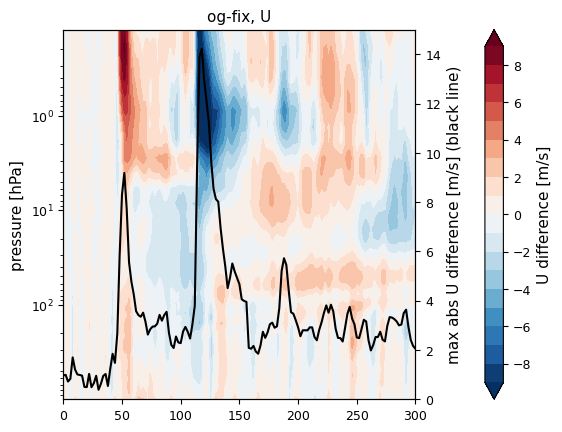

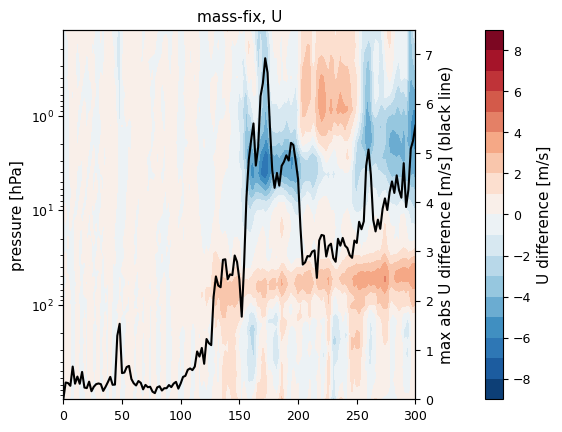

In [7]:
TIME, LEV = np.meshgrid(time, lev)


#var1= (Uem_lv_og - Uem_lv_fix).T
var1= (U_lv_og[0] - U_lv_fix[0]).T
levels = np.arange(-9, 10, 1)
norm  = colors.TwoSlopeNorm(vmin=min(levels), vcenter=0., vmax=max(levels))

cf = plt.contourf(TIME, LEV, var1, levels=levels, cmap='RdBu_r', norm=norm, extend='both')
plt.gca().set_yscale('log')
plt.gca().invert_yaxis()
plt.title('og-fix, U')
plt.ylabel('pressure [hPa]')
cb = plt.colorbar(pad= 0.14)
cb.set_label('U difference [m/s]')

ax1 = plt.gca().twinx()
#ax1.set_yscale('log')
ax1.plot(time, np.abs(var1).max(dim='lev'), '-k')
ax1.set_ylim([1e-3, 2e1])
ax1.set_ylim([0, 15])
ax1.set_ylabel('max abs U difference [m/s] (black line)')

plt.figure()

#var1= (Uem_lv_mass - Uem_lv_fix).T
var1= (U_lv_mass[0] - U_lv_fix[0]).T
plt.contourf(TIME, LEV, var1, levels=cf.levels, norm=norm, cmap='RdBu_r')
plt.gca().set_yscale('log')
plt.gca().invert_yaxis()
plt.title('mass-fix, U')
plt.ylabel('pressure [hPa]')
cb = plt.colorbar(pad= 0.14)
cb.set_label('U difference [m/s]')

ax2 = plt.gca().twinx()
#ax2.set_yscale('log')
ax2.plot(time, np.abs(var1).max(dim='lev'), '-k')
ax2.set_ylim([1e-3, 2e1])
ax2.set_ylim([0, 7.5])
ax2.set_ylabel('max abs U difference [m/s] (black line)')

plt.show()


In [8]:
np.abs(var1).max(dim='lev')

<xarray.DataArray 'U' (time: 151)>
array([0.        , 0.33991563, 0.32953666, 0.27311644, 0.66383254,
       0.31586555, 0.46091709, 0.31430503, 0.55580284, 0.23775506,
       0.2264707 , 0.35707288, 0.16382318, 0.2546535 , 0.30726224,
       0.32095336, 0.30629917, 0.16967723, 0.25320441, 0.34987356,
       0.45439789, 0.29415737, 0.29746638, 1.28961885, 1.53180719,
       0.53114724, 0.54249414, 0.65442232, 0.67710934, 0.41167799,
       0.32437276, 0.28007792, 0.37066323, 0.33353499, 0.20163585,
       0.29238546, 0.24555836, 0.25396734, 0.15485285, 0.12459347,
       0.24164805, 0.26401552, 0.1771575 , 0.2247506 , 0.22477691,
       0.28877415, 0.24688857, 0.31865837, 0.35341379, 0.21618956,
       0.32202948, 0.45426752, 0.47552398, 0.59706332, 0.6259154 ,
       0.59179806, 0.66360715, 0.97013111, 0.86674973, 1.04242438,
       0.72012784, 1.22311279, 1.13816346, 1.09842242, 2.07462321,
       2.492287  , 2.30766137, 2.27397737, 2.83014896, 2.84122608,
       2.4354719 , 2.5339021 , 2.51952982, 2.9175119 , 2.78821755,
       2.42539878, 1.67588253, 2.73192246, 4.08707163, 4.85774189,
       5.2574855 , 5.59718673, 4.7419729 , 5.11811672, 6.14905842,
       6.41351074, 6.92037423, 6.62482836, 5.53443164, 4.64313398,
       4.2906647 , 4.59346729, 4.33580569, 4.73605387, 4.82036865,
       4.95036779, 4.84436079, 5.20354556, 5.15901084, 4.82631002,
       4.46694115, 3.49171239, 2.73372911, 2.77860736, 2.90568891,
       2.89831701, 2.99682371, 3.0206498 , 2.46375958, 3.22253785,
       3.33473612, 3.31945003, 2.89774198, 3.11047495, 3.15718703,
       2.8662156 , 2.79069324, 3.2568243 , 3.11723585, 3.27451588,
       3.11890102, 3.06871303, 2.92383139, 2.87024446, 3.22087131,
       3.17276445, 3.60197477, 3.45058542, 3.61161978, 4.7339236 ,
       5.06779098, 4.55408565, 3.64271142, 3.40608521, 3.64530169,
       3.45877992, 3.86351215, 4.07691198, 3.84106027, 4.20657341,
       4.42101125, 4.18739292, 4.54321307, 4.24624459, 4.09076185,
       4.79123295, 3.9008105 , 4.25586975, 5.08363966, 5.25481061,
       5.55240234])
Coordinates:
  * time     (time) int64 0 2 4 6 8 10 12 14 ... 286 288 290 292 294 296 298 300

As we can see, the original and fixed versions differ considerably, which was to be expected. But, the fixed and mass ensemble versions also differ, wich shouldn't be the case. What happened? We can even see that the differences between them highlight the position of the volcanic plume. Most likely a namelist setting is different between the two...(and I suspect it might be the injection height?). Let's have a look at the run files...

FIXED ENS01
_________

    ncdata     = "/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/hsw_cases/E3SM_ne16_L72_FIDEAL_3year_ensICs/run/E3SM_ne16_L72_FIDEAL_3year_ensICs.eam.i.0002-05-01-00000.nc.newCoordNames"
    pertlim                 = 0.00010000200000000001
    cldera_sai_blw_ash      = 0.00001
    cldera_sai_blw_so2      = 0.01
    cldera_sai_blw_sulf     = 29
    cldera_sai_bsw_ash      = 400
    cldera_sai_bsw_so2      = 400
    cldera_sai_bsw_sulf     = 1900
    cldera_sai_duration     = 24
    cldera_sai_lat0         =  15.15
    cldera_sai_lon0         =  120.35
    cldera_sai_mash         =  50.0
    cldera_sai_mso2         =  17.0
    cldera_sai_rkash        =  1.0
    cldera_sai_rkso2        =  25.0
    cldera_sai_rksulf       =  360.0
    cldera_sai_t0           = 90
    cldera_sai_w            =  2.04
    cldera_sai_z0           = 14
    cldera_sai_z_cool       = 100
    cldera_sai_zeta         = 0.004
    cldera_sai_tracers_flag      = .true.
    cldera_sai_read_from_ic_file = .false.
    cldera_sai_stratheating      = .true.
    cldera_sai_surfcooling       = .true.
    cldera_sai_formsulfate       = .true.


MASS 1.00X ENS01
______________

    ncdata     = "/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members_ics/ens05_ic.nc"
    pertlim                = 0.00010000200000000001
    cldera_sai_blw_ash     =  0.00001
    cldera_sai_blw_so2     =  0.01
    cldera_sai_blw_sulf    =  29
    cldera_sai_bsw_ash     =  400
    cldera_sai_bsw_so2     =  400
    cldera_sai_bsw_sulf    =  1900
    cldera_sai_duration    =  24.0
    cldera_sai_lat0        = 15.15
    cldera_sai_lon0        = 120.35
    cldera_sai_mash        =  50.0
    cldera_sai_mso2        = 17.0
    cldera_sai_rkash       =  1.0
    cldera_sai_rkso2       =  25.0
    cldera_sai_rksulf      =  360.0
    cldera_sai_t0          = 90
    cldera_sai_w           =  2.04
    cldera_sai_z0          =  14.0
    cldera_sai_z_cool      =  100
    cldera_sai_zeta        =  0.004
    cldera_sai_read_from_ic_file = .false.
    cldera_sai_stratheating      = .true.
    cldera_sai_surfcooling       = .true.
    cldera_sai_tracers_flag      = .true.
    cldera_sai_formsulfate       = .true.

    

Hmm, okay... they look the same. Let's double check these initial condition files

In [9]:
ic_mass = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members_ics/ens05_ic.nc'
ic_fix = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/hsw_cases/E3SM_ne16_L72_FIDEAL_3year_ensICs/run/E3SM_ne16_L72_FIDEAL_3year_ensICs.eam.i.0002-05-01-00000.nc.newCoordNames'

ic_mass = xr.open_dataset(ic_mass)
ic_fix = xr.open_dataset(ic_fix)

err = np.abs(ic_mass['U'] - ic_fix['U'])
print(np.sum(err))

<xarray.DataArray 'U' ()>
array(0.)


????
Okay, they are identical...
checking pertlim for all members now:

FIXED ENS
_________
    lattice.expand('pertlim', values=np.array([1e-4+2e-9, 1e-4+1e-9, 1e-4-1e-9, 1e-4-2e-9, 1e-4+2.5e-9]))
    sfx = ['ens01', 'ens02', 'ens03', 'ens04', 'ens05']


MASS 1.00X ENS
______________

    pertlim_vals = np.array([1e-4+2e-9, 1e-4+1e-9, 1e-4-1e-9, 1e-4-2e-9, 1e-4+2.5e-9, 1e-4+1.5e-9, 1e-4-1.5e-9, 1e-4-2.5e-9, 1e-4+1.7e-9, 1e-4-1.7e-9])

nope... these also match... (the first 5 members)



ACTUALLY, they seem to drift apart even more the eruption... how could that possibly be? Different CLDERA_E3SM version?

No, the difference is too great. But HOLD UP, I've just discovered that the data that we have on the NERSC project directory seems to be outdated! Summary I jsut sent to Jerry:

__________________________

Hi Jerry. If you recall, there was a time back in the summer where we once grew suspicious of the limvar mass ensemble. After some digging, we discovered that when you guys had originally ran it, it was done with an old version of the code, and outdated parameter values for HSW. After looking through your run directories at `/pscratch/sd/j/jwatkins/CLDERA/HSW-simulations/` , it seems that the incorrect runs correspond to `low_var_mass_ens` (from early April), while the corrected runs are in `low_var_mass_ens2` (from early June). When I compare these to the project data at `/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_mass_ens` , it seems like the old runs are still there (they are from April).

I also see that in your `low_var_mass_ens2`  directory, only the `1.00X` mass samples were even run there. This suggests that maybe the rest were ran on Sandia? And perhaps that’s where the corrected data is, and that’s where most groups have been accessing it from? If the answer is yes, then that’s fine, just wanting to double check.

Sorry to bring all of this back up, I got myself into a huge knot of confusion while trying to make paper figures haha

__________________________
If what I said to Jerry is correct, then the most recent `ens01_mass1.00X` data in his local scratch space might match my newest run... let's test... this run will be called `massupdate`

In [36]:
# ========== read data ==========

lv_loc_massupdate   = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/tmp2'
lv_label_massupdate   = 'updatedMassLimvarEns_comp'

out    = '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/hswPaperFigs'
vars   = ['AOD', 'U']
N = 5

print('done')

done


In [37]:
print('opening data...')
ens_lv_massupdate   = xr.open_dataset('{}/E3SM_ne16pg2_ne16pg2_L72_FIDEAL_SAI__ens01_mass1.00X.eam.h2.0001-01-01-00000.regrid.91x180_bilinear.nc'.format(lv_loc_massupdate))[vars]

latslice  = slice(-5, 35) # for meridional-means

# --- reassign time dim to day integer, slice to day 300
print('converting time coordinates...')
ens_lv_massupdate = ens_lv_massupdate.assign_coords(time=ctb.time2day(ens_lv_massupdate.time))
ens_lv_massupdate = ens_lv_massupdate.sel(time=ens_lv_massupdate.time%2 == 0).sel(time = slice(0, 300))

print('done')

opening data...
converting time coordinates...
done


In [38]:
# ========== reduce variables ==========

U_lv_massupdate   = ens_lv_massupdate['U'].mean('lon')
U_lv_massupdate   = U_lv_massupdate.sel(lat=latslice).weighted(weights).mean('lat')
    
print('done')

done


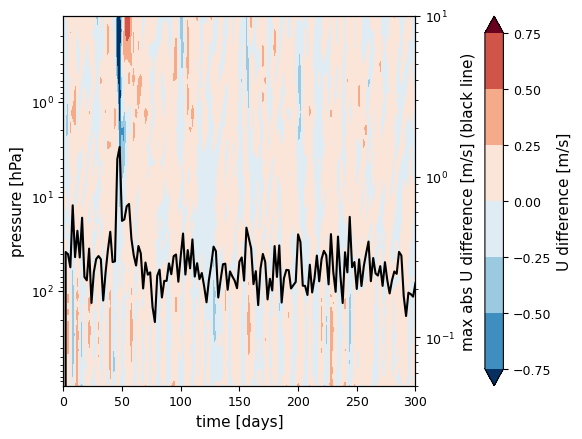

In [57]:
TIME, LEV = np.meshgrid(time, lev)


#var1= (Uem_lv_og - Uem_lv_fix).T
var1= (U_lv_massupdate - U_lv_fix[0]).T
levels = np.arange(-0.75, 0.76, 0.25)
norm  = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

cf = plt.contourf(TIME, LEV, var1, levels=levels, cmap='RdBu_r', extend='both', norm=norm)
plt.gca().set_yscale('log')
plt.gca().invert_yaxis()
#plt.title('massupdate-fix, U')
plt.ylabel('pressure [hPa]')
plt.xlabel('time [days]')
cb = plt.colorbar(pad= 0.14)
cb.set_label('U difference [m/s]')

ax1 = plt.gca().twinx()
ax1.set_yscale('log')
ax1.plot(time, np.abs(var1).max(dim='lev'), '-k')
ax1.set_ylim([5e-2, 1e1])
#ax1.set_ylim([0, 15])
ax1.set_ylabel('max abs U difference [m/s] (black line)')

plt.show()


Okay, problem solved...
Not sure why there is still a perisstent difference of ~0.1-1 m/s, though... could that be due to the non-BFB nature of the newest version of the repo? Dunno. The fact that the error is not building over the simulation suggests that it was not a discrepancy with the actual run, though... possibly the remap? both used bilinear interpolation, so I'm not sure what could explain that 
Let's check the native grid data real quick...

In [59]:
massupdate_data = xr.open_dataset('/pscratch/sd/j/jwatkins/CLDERA/HSW-simulations/low_var_mass_ens2/outputs/E3SM_ne16pg2_ne16pg2_L72_FIDEAL_SAI__ens01_mass1.00X/run/E3SM_ne16pg2_ne16pg2_L72_FIDEAL_SAI__ens01_mass1.00X.eam.h2.0001-01-01-00000.nc')

massupdate_data = massupdate_data.assign_coords(time=ctb.time2day(massupdate_data.time))
massupdate_data = massupdate_data.sel(time=massupdate_data.time%2 == 0).sel(time = slice(0, 300))

fix_data = xr.open_dataset('/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/extra_LIMVAR_outputs_for_hsw_paper/ens_members/HSW_SAI_ne16pg2_L72_1200day_extraRunsForHSWPaper_LIMVAR__ens01/run/HSW_SAI_ne16pg2_L72_1200day_extraRunsForHSWPaper_LIMVAR__ens01.eam.h2.0001-01-01-00000.nc')
fix_data = fix_data.assign_coords(time=ctb.time2day(fix_data.time))
fix_data = fix_data.sel(time=fix_data.time%2 == 0).sel(time = slice(0, 300))

#lat = massupdate_data['lat']
#
#print('removing otuside of lat band')
# zero out vars outside of [-5,35]
#for i in range(len(massupdate_data.ncol)):
#    if(lat[i] < -5 or lat[i] > 35):
#        massupdate_data['U'][:,:,i] = 0
#        fix_data['U'][:,:,i] = 0

print('done')

done


In [60]:
maxUdiff = np.abs(massupdate_data['U'] - fix_data['U']).max(dim=('ncol'))
print('done')

done


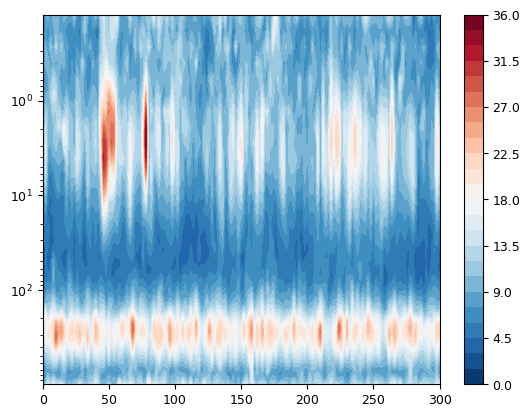

In [61]:
plt.contourf(TIME, LEV, maxUdiff.T, cmap='RdBu_r', levels=30)
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.colorbar()
plt.show()

Alright, I dunno, this looks significant, but it's most liekly just the fact that one was output on averaged 2-daily, and the other was output on averaged 1-daily... I guess let's check that... 

turning 1-daily avg into 2-daily avg...
done


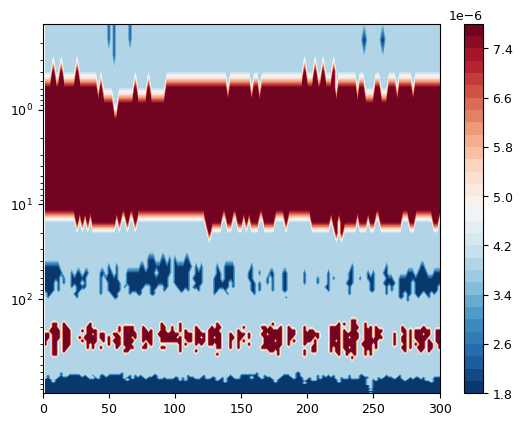

In [62]:
massupdate_data = xr.open_dataset('/pscratch/sd/j/jwatkins/CLDERA/HSW-simulations/low_var_mass_ens2/outputs/E3SM_ne16pg2_ne16pg2_L72_FIDEAL_SAI__ens01_mass1.00X/run/E3SM_ne16pg2_ne16pg2_L72_FIDEAL_SAI__ens01_mass1.00X.eam.h2.0001-01-01-00000.nc')

massupdate_data_odddays = massupdate_data.assign_coords(time=ctb.time2day(massupdate_data.time) + 1)
massupdate_data_odddays = massupdate_data_odddays.sel(time=massupdate_data_odddays.time%2 == 0).sel(time = slice(0, 300))

massupdate_data = massupdate_data.assign_coords(time=ctb.time2day(massupdate_data.time))
massupdate_data = massupdate_data.sel(time=massupdate_data.time%2 == 0).sel(time = slice(0, 300))

print('turning 1-daily avg into 2-daily avg...')
# turn into a 2-daily average... not sure if this is legit
massupdate_data['U'] = (massupdate_data_odddays['U'] + massupdate_data['U']) / 2

maxUdiff = np.abs(massupdate_data['U'] - fix_data['U']).max(dim=('ncol'))
print('done')

plt.contourf(TIME, LEV, maxUdiff.T, cmap='RdBu_r', levels=30)
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.colorbar()
plt.show()

Ok. Good. It's correct. Let's go back and check the U stats then...

In [63]:
# ========== read data ==========

lv_loc_massupdate   = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/tmp2'
lv_label_massupdate   = 'updatedMassLimvarEns_comp'

out    = '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/hswPaperFigs'
vars   = ['AOD', 'U']
N = 5

print('done')

print('opening data...')
ens_lv_massupdate   = xr.open_dataset('{}/E3SM_ne16pg2_ne16pg2_L72_FIDEAL_SAI__ens01_mass1.00X.eam.h2.0001-01-01-00000.regrid.91x180_bilinear.nc'.format(lv_loc_massupdate))[vars]

latslice  = slice(-5, 35) # for meridional-means

# --- reassign time dim to day integer, slice to day 300
print('converting time coordinates...')

ens_lv_massupdate_oddays = ens_lv_massupdate.assign_coords(time=ctb.time2day(ens_lv_massupdate.time)+1)
ens_lv_massupdate_oddays = ens_lv_massupdate_oddays.sel(time=ens_lv_massupdate_oddays.time%2 == 0).sel(time = slice(0, 300))

ens_lv_massupdate = ens_lv_massupdate.assign_coords(time=ctb.time2day(ens_lv_massupdate.time))
ens_lv_massupdate = ens_lv_massupdate.sel(time=ens_lv_massupdate.time%2 == 0).sel(time = slice(0, 300))

print('done')

print('turning 1-daily avg into 2-daily avg...')
ens_lv_massupdate['U'] = (ens_lv_massupdate_oddays['U'] + ens_lv_massupdate['U']) / 2

# ========== reduce variables ==========
print('reducing U...')

U_lv_massupdate   = ens_lv_massupdate['U'].mean('lon')
U_lv_massupdate   = U_lv_massupdate.sel(lat=latslice).weighted(weights).mean('lat')
    
print('done')


done
opening data...
converting time coordinates...
done
turning 1-daily avg into 2-daily avg...
reducing U...
done


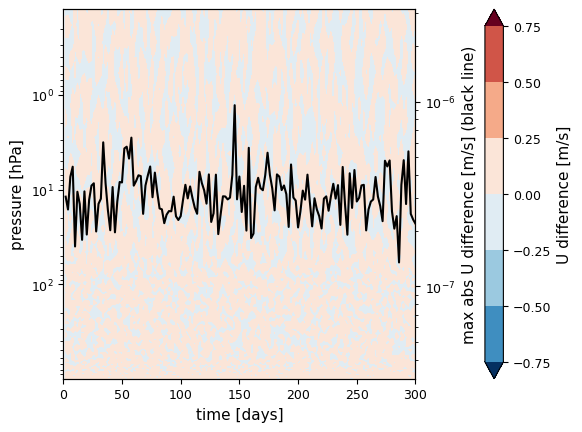

In [64]:
TIME, LEV = np.meshgrid(time, lev)

#var1= (Uem_lv_og - Uem_lv_fix).T
var1= (U_lv_massupdate - U_lv_fix[0]).T
levels = np.arange(-0.75, 0.76, 0.25)
norm  = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

cf = plt.contourf(TIME, LEV, var1, levels=levels, cmap='RdBu_r', norm=norm, extend='both')
plt.gca().set_yscale('log')
plt.gca().invert_yaxis()
#plt.title('massupdate-fix, U')
plt.ylabel('pressure [hPa]')
plt.xlabel('time [days]')
cb = plt.colorbar(pad= 0.14)
cb.set_label('U difference [m/s]')

ax1 = plt.gca().twinx()
ax1.set_yscale('log')
ax1.plot(time, np.abs(var1).max(dim='lev'), '-k')
ax1.set_ylim([1*10**-5.5, 1*10**-7.5][::-1])
ax1.set_ylabel('max abs U difference [m/s] (black line)')

plt.show()

Okay, all is now clear...

Conclusion... need to access FULL corrected ensemble... doesn't seem to be on NERSC... wait for reply from Jerry